In [8]:
import torch
import numpy as np

from pathlib2 import Path

from tqdm.notebook import tqdm 

from src.data.dataloader import get_loaders_with_concepts
from src.data.process_dataset import get_meta

In [9]:
BASE_PATH       = Path(r"C:\Users\alber\Desktop\DTU\2_HCAI\ResponsibleAI\projects\xai\XAI-ResponsibleAI")

raw_datafolder_path = BASE_PATH / 'data/raw/CUB_200_2011'
processed_datafolder_path = BASE_PATH / 'data/processed/CUB_processed/class_attr_data_10'

loaders, normalization = get_loaders_with_concepts(
    raw_data_folder=raw_datafolder_path,
    processed_data_folder=processed_datafolder_path,
    batch_size=128,
)

INFO - Loading data...
INFO - training data loaded !
INFO - validation data loaded !
INFO - test data loaded !


In [10]:
imgs, labels, concepts = [], [], torch.tensor([]) 

for batch_imgs, batch_labels, batch_concepts in tqdm(iter(loaders['train'])):
    concepts = torch.concat([concepts, torch.stack(batch_concepts)], axis=1)
    labels.extend(batch_labels)
    imgs.extend(batch_imgs)
    
imgs = torch.stack(imgs)

  0%|          | 0/37 [00:00<?, ?it/s]

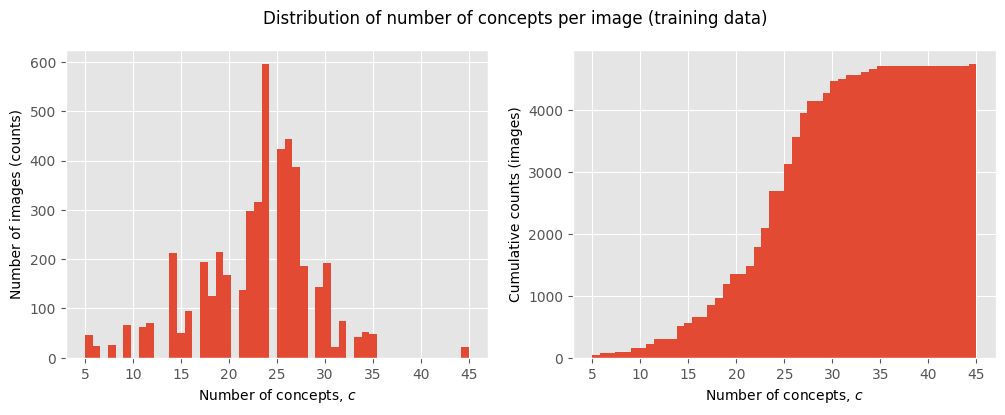

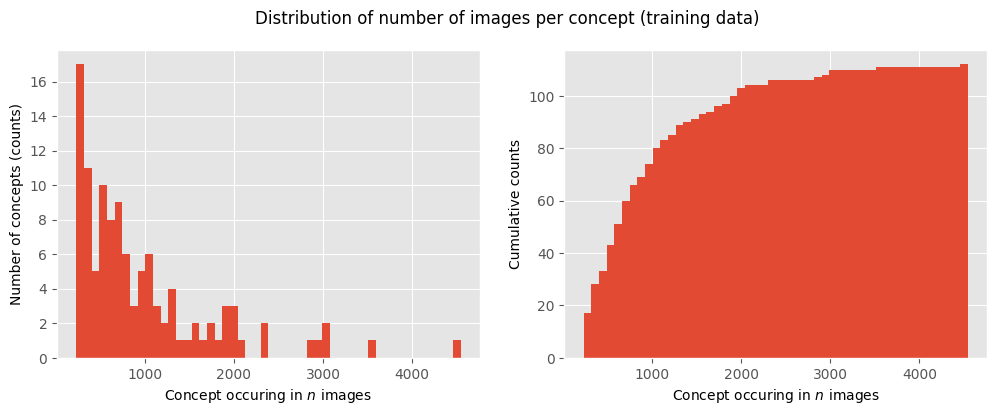

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

concepts_per_image = concepts.sum(axis=0).numpy()
images_per_concept = concepts.sum(axis=1).numpy()

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
axs[0].hist(concepts_per_image, bins=50)
axs[0].set_xlabel('Number of concepts, $c$')
axs[0].set_ylabel('Number of images (counts)')

axs[1].hist(concepts_per_image, bins=50, cumulative=True)
axs[1].set_xlabel('Number of concepts, $c$')
axs[1].set_ylabel('Cumulative counts (images)')

fig.suptitle("Distribution of number of concepts per image (training data)")
plt.show()


fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
axs[0].hist(images_per_concept, bins=50)
axs[0].set_xlabel('Concept occuring in $n$ images')
axs[0].set_ylabel('Number of concepts (counts)')

axs[1].hist(images_per_concept, bins=50, cumulative=True)
axs[1].set_xlabel('Concept occuring in $n$ images')
axs[1].set_ylabel('Cumulative counts')

fig.suptitle("Distribution of number of images per concept (training data)")
plt.show()

In [12]:
# Get dictionaries of label and concept names
meta = get_meta(BASE_PATH / 'data/raw/CUB_200_2011/CUB_200_2011')

idx2concept = meta['concepts']['idx2concept']

In [13]:
dominating_concept = idx2concept[images_per_concept.argmax()].split("::")[0]
category_ = np.where([concept_.startswith(dominating_concept) for concept_ in idx2concept.values()])[0]

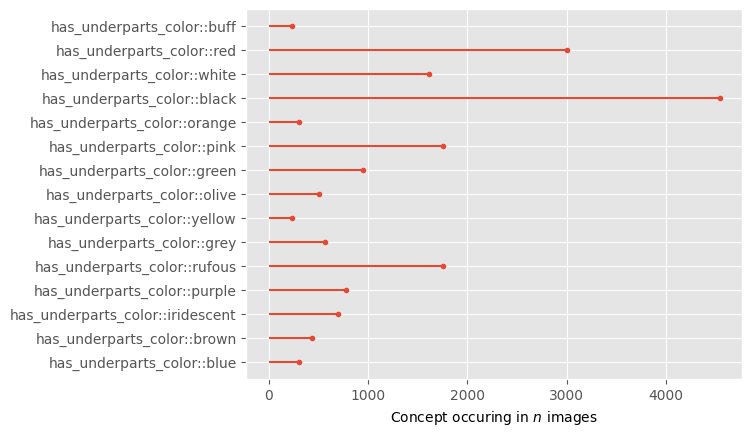

In [14]:
plt.plot(images_per_concept[category_], np.arange(len(category_)), '.')
plt.hlines(np.arange(len(category_)), 0, images_per_concept[category_])  # Stems

plt.xlabel('Concept occuring in $n$ images')
plt.yticks(np.arange(len(category_)), [idx2concept[concept_] for concept_ in category_])
plt.show()

In [15]:
from collections import Counter

label_dist = {k: v for k, v in sorted(Counter(torch.stack(labels).numpy()).items(), key=lambda x: x[0])}

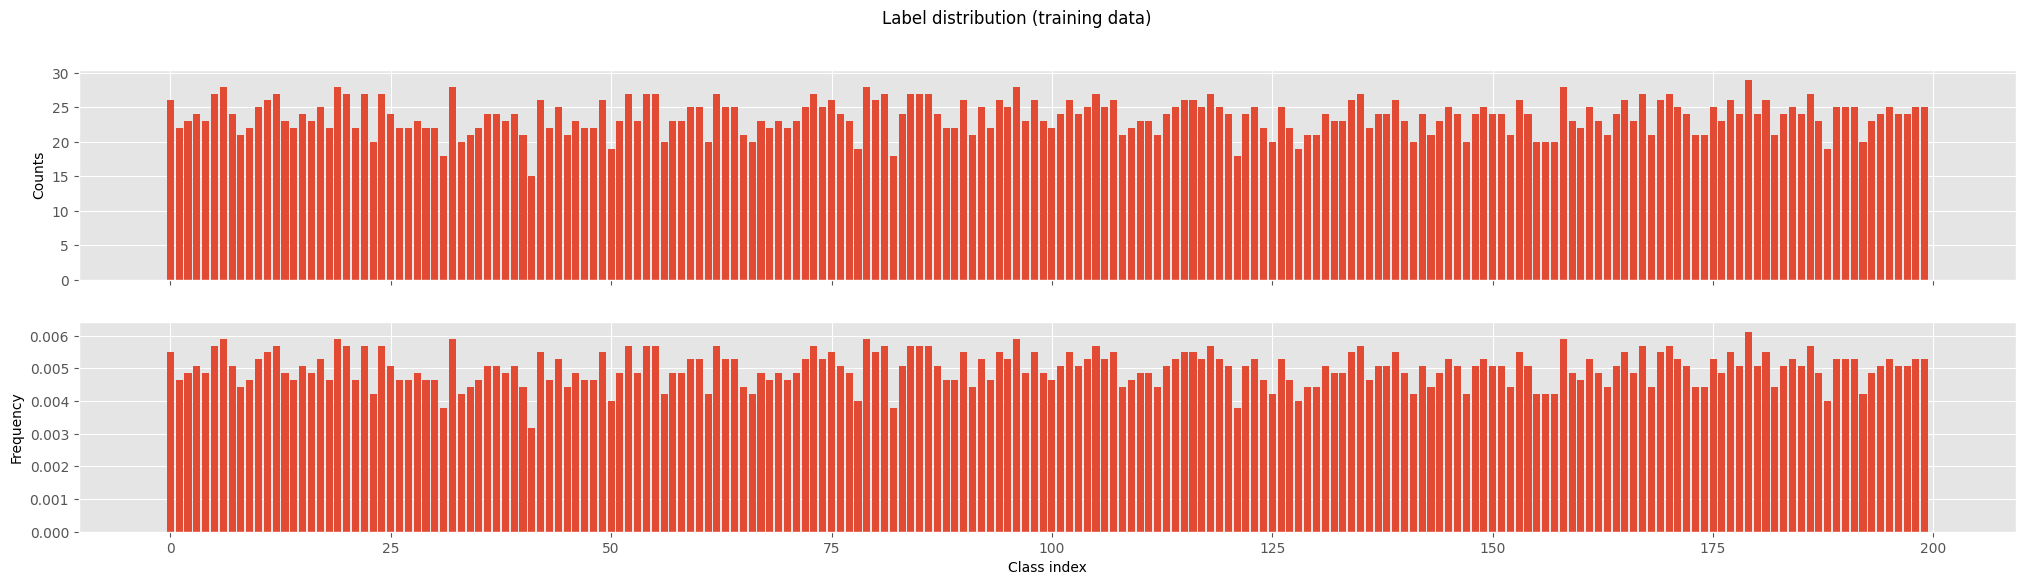

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(25, 6))

axs[0].bar(list(label_dist.keys()), np.array(list(label_dist.values())))
axs[0].set_ylabel('Counts')

axs[1].bar(list(label_dist.keys()), np.array(list(label_dist.values())) / len(labels))
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Class index')

fig.suptitle("Label distribution (training data)")
plt.show()

### Datasplits size

In [24]:
print(f"Training set size: \t{loaders['train'].dataset.__len__()} points")
print(f"Validation set size: \t{loaders['validation'].dataset.__len__()} points")
print(f"Test set size: \t\t{loaders['test'].dataset.__len__()} points")

Training set size: 	4796 points
Validation set size: 	1198 points
Test set size: 		5794 points
